# Particle Discovery Lab
Welcome to the juptyer notebook for the Particle Discovery Lab! 

**Use Shift+Enter to execute a cell.**

Your first task is to load the CMS data file!

In [ ]:
import math, pickle
import matplotlib.pyplot as plt
import statistics as stat
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

# Open the data file provided by your instructor
data = pickle.load(open('DoubleMuParked_100k.pkl','rb'))

## Part 1 : Reconstruction

Each element of `data` contains 8 pieces of information in this order:

`E1`, `E2`, `px1`, `px2`, `py1`, `py2`, `pz1`, `pz2`

(where "1" refers to "muon 1" and "2" refers to "muon 2"). The default unit for these numerical values is the GeV.

First choose a number of events to process, and the boundaries of your analysis window:

In [ ]:
Ntoprocess = int(input("How many events to process? "))

How many events to process? 100000


In [ ]:
Min = float(input("Type in your min (in GeV): "))

Type in your min (in GeV): 2.8


In [ ]:
Max = float(input("Type in your max (in GeV): "))

Type in your max (in GeV): 3.5


In [ ]:
n = int(input("How many x-axis bins would you like? "))

How many x-axis bins would you like? 50


In [ ]:
# Use these to compute a bin width
BinWidth = (Max - Min)/n

# let's get some empty objects ready for later
Masses = []
KineticEnergy = []

Now we're ready to loop over the events in the data file and calculate the invariant mass of particle X. 

### Think: 
 * How will you use the 8 pieces of information to calculate the mass of X?
 * How can you save only the events with a mass value inside your window?
 * How can you calculate the relativistic kinetic energy of particle X? 
 
Write code to calculate the mass and KE of particle X. Store the results in Masses and KineticEnergy if the event has a mass inside your window.

In [ ]:
print ("Looping over",Ntoprocess,"events...")
for i in range(Ntoprocess):
    
    ## COMPUTE the mass of particle X that decays to 2 muons
    ## Recall, the order of information stored in the list called data is given above.
    ## The energy of muon number 1 can be accessed like data[i][1].
    
    E = data[i][0] + data[i][1]  ## conserve E
    Px = data[i][2] + data[i][3] ## conserve px
    Py = data[i][4] + data[i][5] ## conserve py
    Pz = data[i][6] + data[i][7] ## conserve pz
    
    ## Store mass and KE for events with mass inside your window
    ## Invariant mass from E^2 = M^2 + |p|^2   (using natural units with c = 1!)
    ## Tip: make sure your mass value is "real" by using .real after the mass
    M = math.sqrt(E**2 - Px**2 - Py**2 - Pz**2) 
    
    if M > Min and M < Max:
        Masses.append(M.real)
        
        KE = E - M  ## relativistic KE the easy way!
        KineticEnergy.append(KE)
        
print ("Done!")

Looping over 100000 events...
Done!


### HISTOGRAMMING -- create mass and KE histograms              

#### THINK: 
 * What do you expect your kinetic energy histogram to look like?                   
 * What do you expect your mass histogram to look like?                             

Make a quick sketch of what you expect for both plots            

SOLUTION: higher energies are always less probable, so falling from 0. Mass is similar: falling from low -> high, but with a bump
                                                                                         
#### Vocab: imagine plot with 3 bins on x-axis: 0-10, 10-20, 20-30                           
 * "Bin edges": 0, 10, 20, 30                                                              
 * "Bin centers": 5, 15, 25 (want dots on plot to be here!)                                
 * "Bin counts": the height of the histogram bar in each bin
 
#### Tools: plt.hist
plt.hist creates histograms when given a list of data and number of bins.  Look up its arguments and outputs!

Create a MASS histogram by filling in the empty functions below when prompted to do so:

In [ ]:
# Draw your mass histogram. Use plt.show() to draw your plot. 
# Be sure to save your y-axis values! 
plt.figure()
massCounts, massEdges, patches = plt.hist(Masses,n,histtype='step') ## want to keep the y-axis values 
plt.xlabel('dimuon mass (GeV)')
plt.ylabel('number of events')
plt.show()

#### THINK: 
 * What should the ERROR BARS be for each bin?                                      
 * What should you do if the bin has ZERO entries?  

 SOLUTION: Error on N = sqrt(N)
           
Zero is not exact! Just lack of data. Use error_up = 1 (or dig deeper and talk about Poisson upper bound on 0!).
But error bars shouldn't dip below 0 here, that would be unphysical.
 
#### Tools:   plt.errorbar: 

plt.errorbar draws dots+bars when given x-axis bin centers, y-axis bin counts, and up/down uncertainties. Look up its [command options](https://matplotlib.org/stable/gallery/statistics/errorbar_features)                                                                                      

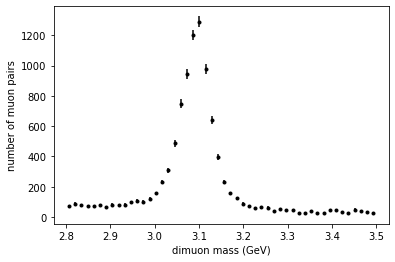

In [ ]:
# Calculate lists of uncertainty values for plt.errorbar
error = [[],[]]
error[0] = np.sqrt(massCounts)
error[1] = np.maximum(np.sqrt(massCounts),np.ones(len(massCounts)))

# Define an array of bin centers
massCenters = massEdges+BinWidth*0.5
massCenters = massCenters[:-1] # Remove the last element in the array

# Draw the new plot with error bars
plt.errorbar(massCenters, massCounts, yerr=error, fmt='.k',ecolor='k')
plt.xlabel('dimuon mass (GeV)')
plt.ylabel('number of muon pairs')
plt.show()

 #### Draw another HISTOGRAM with error bars of counts vs kinetic energy

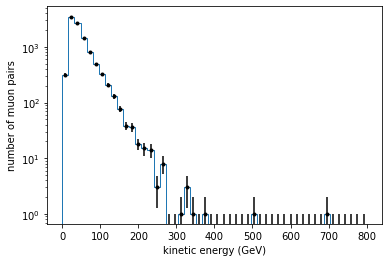

In [ ]:
# Get the y-axis values by drawing a new KE histogram
plt.figure()
keCounts, keEdges, patches = plt.hist(KineticEnergy,n,(0,800),histtype='step',log=True) ## want to keep the y-axis values 

# Calculate lists of uncertainty values for plt.errorbar
keerror = [[],[]]
keerror[0] = np.sqrt(keCounts)
keerror[1] = np.maximum(np.sqrt(keCounts),np.ones(len(keCounts)))

# Define an array of bin centers
keCenters = keEdges+(800/n)*0.5
keCenters = keCenters[:-1] # Remove the last element in the array

# Draw the new plot with error bars
plt.errorbar(keCenters, keCounts, yerr=keerror, fmt='.k',ecolor='k')
plt.xlabel('kinetic energy (GeV)')
plt.ylabel('number of muon pairs')
plt.show()

#### Great work! 
Save these plots to represent your raw data in your report. If you're using a jupyter notebook, save the notebook here. 

## Part 2 : Background Estimation
Fit the background on either side of the signal peak in your mass distribution. 

#### Vocab: imagine a mass plot with a bump in the middle
 * "Peak window": region along x-axis under the peak
 * "background": smoothly falling slope of random events, including some of the events in the peak window
 * "signal": events in the peak window minus the background

In [ ]:
# Choose mass values or bin numbers for where the peak lies
peakmin = float(input('Enter your peak minimum (in GeV)'))

Enter your peak minimum (in GeV)2.93


In [ ]:
peakmax = float(input('Enter your peak maximum (in GeV) '))

Enter your peak maximum (in GeV) 3.3


In [ ]:
# Convert these mass values to bin numbers
iMin = int(round((peakmin-Min)/BinWidth)) # Just an example: fine to hardcode numbers
iMax = int(round((peakmax-Min)/BinWidth))
print (iMin,iMax)

9 36


#### PERFORM a line fit to the background
#### THINK: 
Imagine a line connecting the data on either side of your peak. How could you estimate the function of that line?

In [ ]:
# Using data points from the left and right sides of your mass histograms, evaluate a linear function to represent the background events underneath the peak. 
# Recall, the function of a line is y = mx + b 
avgleft = [stat.mean(massCenters[0:int(n * 0.1)]), stat.mean(massCounts[0:int(n * 0.1)])]
avgright = [stat.mean(massCenters[int(n * 0.9):-1]), stat.mean(massCounts[int(n * 0.9):-1])]
m = (avgright[1] - avgleft[1])/(avgright[0] - avgleft[0])
b = -(m * avgleft[0]) + avgleft[1]

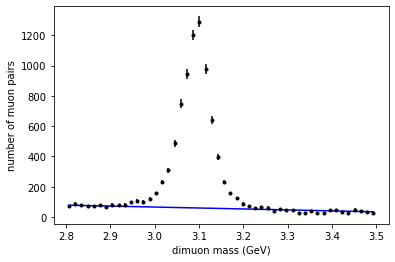

In [ ]:
# Plot your background curve on top of your mass histogram
fittedCounts = list(np.array(massCenters) * m)
fittedCounts = [z+b for z in fittedCounts]

plt.figure()
plt.errorbar(massCenters, massCounts, yerr=error, fmt='.k', ecolor='k')
plt.plot(massCenters,fittedCounts,'b-')
plt.xlabel('dimuon mass (GeV)')
plt.ylabel('number of muon pairs')
plt.show()

### SUBTRACTION -- now you will subtract that background from data

#### THINK: 
Are your estimated bkg values at all uncertain? 

How could you evaluate an uncertainty on the number of background events in each bin?

*SOLUTION: Yes, of course! But we have not discussed covariance and will make the ~safe assumption that our background uncert is small. The pollsf function chooses to return only variances, but you could edit it to return the whole matrix, or you could estimate an uncertainty of 0, or use the Poisson sqrt(N) formula as shown here.*  

What do you expect the curve to look like after background subtraction?

*SOLUTION: After subtraction should look like a ~Gaussian peak*

#### EVALUATE signal = data - background
#### THINK: 
Do you have any bins where the background estimate is larger than the data? What do you think about this situation? 

How could you find the uncertainty in data - background?

*SOLUTION: values less than 0 are not unphysical anymore, since this is an "estimate". Values less than 0 can happen when subtracting background, it's no longer necessarily unphysical. Uncertainty is like radioactivity: err = sqrt(errData^2 + errBkg^2), NOT sqrt after subtracting! You could estimate errBkg = 0, or assume Poisson and say errBkg = sqrt(N)*

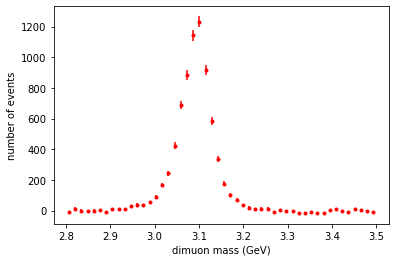

In [ ]:
# Subtract background and plot the resulting signal-only peak with error bars
signalCounts = massCounts - fittedCounts
signalErrors = [[],[]]
signalErrors[0] = np.sqrt(signalCounts + fittedCounts)
signalErrors[1] = np.maximum(np.sqrt(signalCounts + fittedCounts),np.ones(len(signalCounts)))

plt.errorbar(massCenters,signalCounts,yerr=signalErrors,fmt='.r',ecolor='r')
plt.xlabel('dimuon mass (GeV)')
plt.ylabel('number of events')
plt.show()

#### Great work!
Save the data+background and signal-only plots for the analysis section of your report. 

## Part 3 : Characterization
Determine which particle you've discovered and use a fit to find its properties. 

#### EXTRACT the characteristics of your signal peak
#### THINK: 
Which statistical distribution describes your signal peak?

*SOLUTION: they should do well with a Gaussian shape. The initial conditions can be basic like p0=[1, (eyeballed peak center), 0.5]*

#### Tools: 
 * A Gaussian function *Gaus* has been defined below:
    * Inputs: x (list of x-axis values), amplitude, mean, sigma (parameters of a Gaussian distribution)
    * Outputs: list of y-axis values corresponding to the Gaussian curve
 * The *curve_fit* function:
    * Outputs: it returns lists of fitted parameters and uncertainties
    * Inputs: it is given a fit function, x and y-axis values, and initial conditions for the function's parameters
    * Usage Example: gausParams,gausUncerts = curve_fit(fit function, x, y, initial conditions)
    * Read about how to use this function at [scipy.org](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)

In [ ]:
def Gaus(x,amplitude,mean,sigma):
    return amplitude*np.exp(-(x-mean)**2/(2*sigma**2))

Looking at your mass histogram, guess the inital conditions of the Gaussian distribution that would destribe your signal peak.  
You will need to guess the amplipitude, the mean, and the standard deviation.

In [ ]:
initialguess = [1,3,0.1]

# Use curve_fit to fit your signal peak using Gaus as the fit function
gausParams,gausUncerts = curve_fit(Gaus,massCenters,signalCounts,initialguess) 
print (gausParams)

[ 1.15675669e+03  3.09256436e+00 -3.33747482e-02]


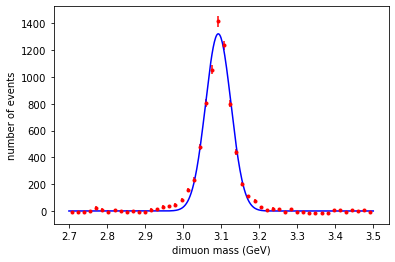

In [ ]:
# Plot the fitted function on top of your signal distribution 
# xGaus below gives you lots of x-axis points to plot a smooth curve
xGaus = np.linspace(Min,Max,501).tolist()

plt.figure()
plt.errorbar(massCenters, signalCounts, yerr=signalErrors, fmt='r.',ecolor='r')
plt.plot(xGaus, Gaus(xGaus,*gausParams), 'b')
plt.xlabel('dimuon mass (GeV)')
plt.ylabel('number of events')
plt.title('Fitted signal')
plt.show()

In [ ]:
# Print out the mean and width of your fitted curve with uncertainties
# SOLUTION: they need to access specific elements of paramsGaus and covariance. The 2nd element is the mean and the 3rd element is the width.
print ("Mean =",gausParams[1],"+/-",gausUncerts[1][1])
print ("Width =",abs(gausParams[2]),"+/-",gausUncerts[2][2])

Mean = 3.0925643630974324 +/- 3.9149780099378537e-07
Width = 0.03337474822540622 +/- 3.9149779959535367e-07


#### COMPARE: the number of signal events in signal peak window to the number of background events under the peak window.
#### THINK: 
How can you find the number of events in the signal peak? 

How can you find the number of bkg events under the peak?

#### PRINT: these values along with their uncertainties

*SOLUTION: NSignal = sum up counts from "sig counts". NBackground = sum up counts from "fittedcounts" (iMin to iMax). Of course, the groups are free to integrate their 2 fitted functions from peakmin to peakmax! For uncertainties, they should be able to show that sqrt(sumtotal) is really what you get from propagation of sqrt(N) errors through the sum.*

In [ ]:
# Print signal and background counts with uncertainties
bkginpeak = sum(fittedCounts[iMin:iMax])
siginpeak = sum(signalCounts[iMin:iMax])
print ('NBkg =',bkginpeak,'+/-',math.sqrt(bkginpeak))
print ('NSig =',siginpeak,'+/-',math.sqrt(siginpeak))

NBkg = 1569.7011235955063 +/- 39.61945385281713
NSig = 7299.298876404492 +/- 85.43593433915551


#### Almost done!
#### THINK: 
 * Can you statistically distinguish signal from background?
 * Can you find this particle with a web search for you mass?

Research this [particle](https://pdg.lbl.gov), find its width (capital Gamma). 
 * Do your mass & width agree with the known values? 
 * Find percent differences and also discrepancy/significance. 
 * If your width is *much* larger than accepted, why might this be?
 
*SOLUTION: Generally their masses should agree within the observed widths, and usually within a few times the parameter uncertainty. For Z bosons (short-lived) the width should also agree because it is large (several GeV). For the mesons their width will be MUCH too large -- the CMS detector resolution is not fine enough to measure the lifetime of these particles and the width is inflated.* 
